In [36]:
import torch
from torch.utils import data
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchinfo import summary
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [3]:
# CPU 혹은 GPU  장치 확인해보기
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cpu')

# 데이터 준비

In [5]:
# 평균이 0.5, 표준편차가 1.0이 되도록 데이터의 분포를 정규화
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))
])

In [6]:
trainset = datasets.MNIST(
    root = "./data/",
    train = True,
    download = True,
    transform = mnist_transform)
testset = datasets.MNIST(
    root = "./data/",
    train = False,
    download = True,
    transform = mnist_transform)

In [7]:
type(trainset)

torchvision.datasets.mnist.MNIST

In [8]:
type(testset)

torchvision.datasets.mnist.MNIST

In [9]:
# 데이터를 데이터로더에 전달
train_loader = torch.utils.data.DataLoader(trainset,
                                          batch_size = 100)
test_loader = torch.utils.data.DataLoader(testset,
                                         batch_size = 100)

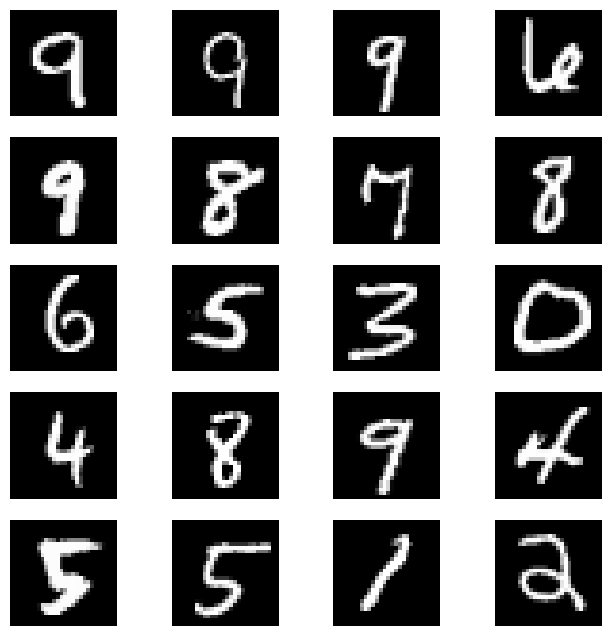

In [11]:
fig = plt.figure(figsize = (8, 8))
columns = 4
rows = 5

for i in range(1, columns * rows + 1):
    img_xy = np.random.randint(len(trainset))
    img = trainset[img_xy][0][0, :, :]
    fig.add_subplot(rows, columns, i)
    
    plt.axis ("off")
    plt.imshow(img, cmap = "gray")
    
plt.show()

In [14]:
# train, test 데이터 크기 확인
print(len(trainset[1][0][0]))
print(len(testset[1][0][0]))

28
28


# 모델 생성

### 합성곱 신경망 모델 생성

In [83]:
class Mnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels=32, kernel_size=5, padding = 2),
            # (28 - 5 + 2 * 2)/1 + 1 =28
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
            # 28 / 2 = 14
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding = 2),
            # (14 - 5 + 2 * 2)/1 + 1 = 14
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2)
            # 14 / 2 = 7
        )
        
        # 전결합층
        self.fc1 = nn.Linear(in_features=64*7*7, out_features=1024) 
        # out_features = 유닛 수
        self.drop = nn.Dropout2d(0.3)
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=10)
            
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # Flatten
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [84]:
model = Mnist()

summary(model)

Layer (type:depth-idx)                   Param #
Mnist                                    --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       832
│    └─BatchNorm2d: 2-2                  64
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-5                       51,264
│    └─BatchNorm2d: 2-6                  128
│    └─ReLU: 2-7                         --
│    └─MaxPool2d: 2-8                    --
├─Linear: 1-3                            3,212,288
├─Dropout2d: 1-4                         --
├─Linear: 1-5                            262,400
├─Linear: 1-6                            2,570
Total params: 3,529,546
Trainable params: 3,529,546
Non-trainable params: 0

In [85]:
# 합성곱 신경망 파라미터 정의
learning_rate = 0.001
model = Mnist() # 위에서 만든 class를 객체화
model.to(device)

criterion = nn.CrossEntropyLoss() # 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # adam
print(model)

Mnist(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (drop): Dropout2d(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


# 모델 학습2

In [86]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device),labels.to(device)
        # 모델이 데이터를 처리하기 위해서는 모델과 데이터가 동일한 장치에 있어야 함
        
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels) # autograd = 자동미분계산
        # Autograd는 자동 미분을 수행하는 파이토치의 핵심 패키지
        # 자동 미분에 대한 값을 저장
        
        # 해당 과정은 파이토치에서 항상 고정
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad() # optimizer가 실행되기 전에 초기화 시킴
        loss.backward() # 오차 역전파
        optimizer.step()
        count += 1
        
        if not (count % 50): # = 50으로 나누어 떨어졌을 때
            total = 0
            correct = 0
            for images, labels, in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device) # (출력값, 인덱스)[1]
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels) # 전체 정답값 갯수 total에 담기
                
            accuracy = correct * 100 / total # 정확도 계산
            loss_list.append(loss.data) # loss = criterion(outputs, labels)
            # 손실값을 50 steps 마다 기록을 남길 것
            iteration_list.append(count) # step = iteration
            accuracy_list.append(accuracy)
            
        if not (count % 500):
            print(f"Iteration: {count}, Loss: {loss.data}, Accucacy: {accuracy}%")
            # 로그 뿌리기

Iteration: 500, Loss: 0.1338394731283188, Accucacy: 96.27999877929688%
Iteration: 1000, Loss: 0.21552427113056183, Accucacy: 97.7699966430664%
Iteration: 1500, Loss: 0.06444184482097626, Accucacy: 98.80999755859375%
Iteration: 2000, Loss: 0.05918227508664131, Accucacy: 98.58000183105469%
Iteration: 2500, Loss: 0.013481019996106625, Accucacy: 98.54000091552734%
Iteration: 3000, Loss: 0.22456355392932892, Accucacy: 98.83999633789062%


# 모델 생성2

In [169]:
class Mnist2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels=32, kernel_size=3),
            # (28 - 3 + 2 * 0)/1 + 1 =26
            nn.ReLU(),
            nn.MaxPool2d(2)
            # 26 / 2 = 13
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            # (13 - 3 + 2 * 0)/1 + 1 = 11
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2)
            # 11 / 2 = 5.5
        )
        self.layer3 = nn.Sequential(
            nn.Linear(in_features=64 * 7 * 7, out_features = 10),
            nn.ReLU(inplace = True))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # Flatten
        out = self.layer3(out)
        return out

In [170]:
model2 = Mnist2()

summary(model2)

Layer (type:depth-idx)                   Param #
Mnist2                                   --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       320
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-4                       18,496
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-3                        --
│    └─Linear: 2-7                       31,370
│    └─ReLU: 2-8                         --
Total params: 50,186
Trainable params: 50,186
Non-trainable params: 0

In [171]:
# 합성곱 신경망 파라미터 정의
learning_rate = 0.001
model2 = Mnist2() # 위에서 만든 class를 객체화
model2.to(device)

criterion = nn.CrossEntropyLoss() # 손실 함수
optimizer = torch.optim.Adam(model2.parameters(), lr = learning_rate) # adam
print(model2)

Mnist2(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=3136, out_features=10, bias=True)
    (1): ReLU(inplace=True)
  )
)


# 모델 학습

In [172]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device),labels.to(device)
        # 모델이 데이터를 처리하기 위해서는 모델과 데이터가 동일한 장치에 있어야 함
        
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels) # autograd = 자동미분계산
        # Autograd는 자동 미분을 수행하는 파이토치의 핵심 패키지
        # 자동 미분에 대한 값을 저장
        
        # 해당 과정은 파이토치에서 항상 고정
        outputs = model2(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad() # optimizer가 실행되기 전에 초기화 시킴
        loss.backward() # 오차 역전파
        optimizer.step()
        count += 1
        
        if not (count % 50): # = 50으로 나누어 떨어졌을 때
            total = 0
            correct = 0
            for images, labels, in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model2(test)
                predictions = torch.max(outputs, 1)[1].to(device) # (출력값, 인덱스)[1]
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels) # 전체 정답값 갯수 total에 담기
                
            accuracy = correct * 100 / total # 정확도 계산
            loss_list.append(loss.data) # loss = criterion(outputs, labels)
            # 손실값을 50 steps 마다 기록을 남길 것
            iteration_list.append(count) # step = iteration
            accuracy_list.append(accuracy)
            
        if not (count % 500):
            print(f"Iteration: {count}, Loss: {loss.data}, Accucacy: {accuracy}%")
            # 로그 뿌리기

Iteration: 500, Loss: 2.8679375648498535, Accucacy: 12.630000114440918%
Iteration: 1000, Loss: 2.767152786254883, Accucacy: 15.100000381469727%
Iteration: 1500, Loss: 2.7769227027893066, Accucacy: 16.540000915527344%
Iteration: 2000, Loss: 2.8201231956481934, Accucacy: 17.260000228881836%
Iteration: 2500, Loss: 2.633742570877075, Accucacy: 18.030000686645508%
Iteration: 3000, Loss: 2.6524972915649414, Accucacy: 18.049999237060547%


# 모델 생성3

### 심층 신경망 모델 생성

In [174]:
class Mnist3(nn.Module):
    def __init__(self):
        super().__init__()
        # 28 * 28 = 784
        self.fc1 = nn.Linear(in_features = 784, out_features = 256)
        self.drop = nn.Dropout2d(0.3)
        self.fc2 = nn.Linear(in_features = 256, out_features = 128)
        self.fc3 = nn.Linear(in_features = 128, out_features = 10)
        
    def forward(self, input_data):
        out = input_data.view(-1, 784)
        # 활성화함수는 F.relu()로 forward() 함수에서 정의할 수도 있고
        # nn.ReLU()로  __init__() 에서 정의할 수도 있음
        out = F.relu(self.fc1(out)) # fc = fully connected 전결합층
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [175]:
# 심층 신경망 파라미터 정의
learning_rate = 0.001
model3 = Mnist3()
model3.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr = learning_rate)
print(model3)

Mnist3(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout2d(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


# 모델 학습3

In [176]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device),labels.to(device)
        # 모델이 데이터를 처리하기 위해서는 모델과 데이터가 동일한 장치에 있어야 함
        
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels) # autograd = 자동미분계산
        # Autograd는 자동 미분을 수행하는 파이토치의 핵심 패키지
        # 자동 미분에 대한 값을 저장
        
        # 해당 과정은 파이토치에서 항상 고정
        outputs = model3(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad() # optimizer가 실행되기 전에 초기화 시킴
        loss.backward() # 오차 역전파
        optimizer.step()
        count += 1
        
        if not (count % 50): # = 50으로 나누어 떨어졌을 때
            total = 0
            correct = 0
            for images, labels, in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model3(test)
                predictions = torch.max(outputs, 1)[1].to(device) # (출력값, 인덱스)[1]
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels) # 전체 정답값 갯수 total에 담기
                
            accuracy = correct * 100 / total # 정확도 계산
            loss_list.append(loss.data) # loss = criterion(outputs, labels)
            # 손실값을 50 steps 마다 기록을 남길 것
            iteration_list.append(count) # step = iteration
            accuracy_list.append(accuracy)
            
        if not (count % 500):
            print(f"Iteration: {count}, Loss: {loss.data}, Accucacy: {accuracy}%")
            # 로그 뿌리기

Iteration: 500, Loss: 0.3700803816318512, Accucacy: 90.94000244140625%
Iteration: 1000, Loss: 0.2579551041126251, Accucacy: 93.4800033569336%
Iteration: 1500, Loss: 0.32196009159088135, Accucacy: 94.54000091552734%
Iteration: 2000, Loss: 0.10717396438121796, Accucacy: 95.36000061035156%
Iteration: 2500, Loss: 0.06886934489011765, Accucacy: 94.69000244140625%
Iteration: 3000, Loss: 0.2008088231086731, Accucacy: 94.93000030517578%


# 모델 생성4

### ### 합성곱 신경망 모델 생성2

In [178]:
class Mnist4(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels=32, kernel_size=3, padding = 1),
            # (28 - 3 + 2 * 1)/1 + 1 =28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
            # 28 / 2 = 14
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1),
            # (14 - 3 + 2 * 1)/1 + 1 = 14
            nn.ReLU(),
            nn.MaxPool2d(2)
            # 14 / 2 = 7
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1),
            # (7 - 3 + 2 * 1)/1 + 1 = 7
            nn.ReLU(),
            nn.MaxPool2d(2)
            # 7 / 2 = 3.5
        )
        
        # 전결합층
        self.fc1 = nn.Linear(in_features=64*7*7, out_features=1024) 
        # out_features = 유닛 수
        self.drop = nn.Dropout2d(0.3)
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=10)
            
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1) # Flatten
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [179]:
# 심층 신경망 파라미터 정의
learning_rate = 0.001
model4 = Mnist4()
model4.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model4.parameters(), lr = learning_rate)
print(model4)

Mnist4(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (drop): Dropout2d(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


# 모델 학습4

In [180]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device),labels.to(device)
        # 모델이 데이터를 처리하기 위해서는 모델과 데이터가 동일한 장치에 있어야 함
        
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels) # autograd = 자동미분계산
        # Autograd는 자동 미분을 수행하는 파이토치의 핵심 패키지
        # 자동 미분에 대한 값을 저장
        
        # 해당 과정은 파이토치에서 항상 고정
        outputs = model4(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad() # optimizer가 실행되기 전에 초기화 시킴
        loss.backward() # 오차 역전파
        optimizer.step()
        count += 1
        
        if not (count % 50): # = 50으로 나누어 떨어졌을 때
            total = 0
            correct = 0
            for images, labels, in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model4(test)
                predictions = torch.max(outputs, 1)[1].to(device) # (출력값, 인덱스)[1]
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels) # 전체 정답값 갯수 total에 담기
                
            accuracy = correct * 100 / total # 정확도 계산
            loss_list.append(loss.data) # loss = criterion(outputs, labels)
            # 손실값을 50 steps 마다 기록을 남길 것
            iteration_list.append(count) # step = iteration
            accuracy_list.append(accuracy)
            
        if not (count % 500):
            print(f"Iteration: {count}, Loss: {loss.data}, Accucacy: {accuracy}%")
            # 로그 뿌리기

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x1152 and 3136x1024)

# 모델 생성5

In [190]:
class Mnist5(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels=32, kernel_size=3, padding = 1),
            # (28 - 3 + 2 * 1)/1 + 1 =28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
            # 28 / 2 = 14
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1),
            # (14 - 3 + 2 * 1)/1 + 1 = 14
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2)
            # 14 / 2 = 7
        )
        
        # 전결합층
        self.fc1 = nn.Linear(in_features=64*7*7, out_features=10) 
            
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # Flatten
        out = self.fc1(out)
        return out

In [191]:
# 심층 신경망 파라미터 정의
learning_rate = 0.001
model5 = Mnist5()
model5.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model5.parameters(), lr = learning_rate)
print(model5)

Mnist5(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=3136, out_features=10, bias=True)
)


# 모델 학습5

In [192]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device),labels.to(device)
        # 모델이 데이터를 처리하기 위해서는 모델과 데이터가 동일한 장치에 있어야 함
        
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels) # autograd = 자동미분계산
        # Autograd는 자동 미분을 수행하는 파이토치의 핵심 패키지
        # 자동 미분에 대한 값을 저장
        
        # 해당 과정은 파이토치에서 항상 고정
        outputs = model5(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad() # optimizer가 실행되기 전에 초기화 시킴
        loss.backward() # 오차 역전파
        optimizer.step()
        count += 1
        
        if not (count % 50): # = 50으로 나누어 떨어졌을 때
            total = 0
            correct = 0
            for images, labels, in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model5(test)
                predictions = torch.max(outputs, 1)[1].to(device) # (출력값, 인덱스)[1]
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels) # 전체 정답값 갯수 total에 담기
                
            accuracy = correct * 100 / total # 정확도 계산
            loss_list.append(loss.data) # loss = criterion(outputs, labels)
            # 손실값을 50 steps 마다 기록을 남길 것
            iteration_list.append(count) # step = iteration
            accuracy_list.append(accuracy)
            
        if not (count % 500):
            print(f"Iteration: {count}, Loss: {loss.data}, Accucacy: {accuracy}%")
            # 로그 뿌리기

Iteration: 500, Loss: 0.10147961974143982, Accucacy: 98.12000274658203%
Iteration: 1000, Loss: 0.04126359149813652, Accucacy: 98.25%
Iteration: 1500, Loss: 0.039959847927093506, Accucacy: 98.6500015258789%
Iteration: 2000, Loss: 0.01594449020922184, Accucacy: 98.6500015258789%
Iteration: 2500, Loss: 0.005076043773442507, Accucacy: 98.80999755859375%
Iteration: 3000, Loss: 0.19605380296707153, Accucacy: 98.62999725341797%


# 풀이

In [194]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [195]:
DEVICE

device(type='cpu')

In [196]:
# 이미지를 텐서로 변경
trasform = transforms.Compose([transforms.ToTensor()])

In [198]:
trainset = datasets.MNIST(
    root = "./data/",
    train = True,
    download = True,
    transform = trasform)
testset = datasets.MNIST(
    root = "./data/",
    train = False,
    download = True,
    transform = trasform)

In [199]:
batch_size = 32

In [202]:
# 데이터 공급 객체 선언
train_loader = data.DataLoader(
    dataset = trainset,
    batch_size = batch_size)

test_loader = data.DataLoader(
    dataset = testset,
    batch_size = batch_size)

In [205]:
class Net(nn.Module):
    def __init__(self):
        '''모델 구조 정의'''
        super().__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 10)
        
    def forward(self, x):
        # 입력 데이터 = x
        # x.shape([배치사이즈, 채널, 높이, 너비])
        x = x.view(-1, 28 * 28)
        
        # x.shape([배치사이즈, 784])
        x = F.relu(self.fc1(x))
        
        # x.shape([배치사이즈, 앞 레이어의 출력 개수])
        x = self.fc2(x)
        
        return x

In [206]:
# 모델 객체 선언
model = Net().to(DEVICE)

In [207]:
# 옵티마이저 설정
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [208]:
# 학습 함수 정의
def train(model, train_loader, optimizer):
    # 모델을 학습 모드로 전환
    model.train()
     
    for batch_idx, (data, target) in enumerate(train_loader): # 하나의 batch = step
        # 학습 데이터를 DEVICE로 보냄
        data, target = data.to(DEVICE), target.to(DEVICE)
        
        # 매 이레테이션 마다 기울기를 계산하기 위해 zero_grad() 호출
        optimizer.zero_grad()
        
        # 실제 모델의 예측값 받아오기
        output = model(data)
        
        # 정답 데이터와의 cross entropy Loss 계산
        # Loss는 mini batch의 클래스의 오차 평균값
        loss = F.cross_entropy(output, target)
        
        # 기울기 계산
        loss.backward()
        
        # 가중치 수정
        optimizer.step()

In [210]:
def evaluate(model, test_loader):
    # 모델을 평가모드로 전환
    model.eval()
    
    # 필요한 변수 초기화
    # test 과정에서의 Loss
    # 실제 모델의 예측이 정답과 맞은 횟수(correct)
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): # 평가 시에는 기울기를 계산하지 않으므로, no_grad를 명시
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
        
            # 모든 오차 계산하기
            test_loss += F.cross_entropy(output, target, reduction = "sum").item()
            # output과 target값을 넣고 오차 계산
            # reduction: str = 'mean'! 기본값은 평균(mean)
            
            # 가장 큰 값을 가진 클래스가 모델의 예측
            # 예측과 정답을 비교하여 일치하면 correct에 1 더하기
            pred = output.max(1, keepdim = True)[1]
            # output.max = arrgmax 역할도 함! 최댓값의 인덱스도 같이 찾아줌!
            
            # eq() : 값이 일치하면 1, 아니면 0
            correct += pred.eq(target.view_as(pred)).sum().item()
            # target.view_as(pred) = target모양을 pred의 모양새와 맞춰주는 것
        
        test_loss /= len(test_loader.dataset) # /= : 나누고 할당행
        # -> reduction = "sum"을 했기 때문에!
        # 로스를 묶어서 평균을 내었음 -> 근데 우리는 reduction에서 sum을 해서 loss 계산이 총합이 되었음 (총 개수)
        # 그래서 나눌 필요가 있음!
        
        # 정확도 계산
        test_accuracy = 100 * correct / len(test_loader.dataset)
        
        return test_loss, test_accuracy

In [212]:
for epoch in range(1, 6):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print(f"[{epoch}] Test Loss : {test_loss:.4f}, Accuracy : {test_accuracy:.2f}%")

[1] Test Loss : 0.4105, Accuracy : 88.85%
[2] Test Loss : 0.3261, Accuracy : 90.67%
[3] Test Loss : 0.2924, Accuracy : 91.81%
[4] Test Loss : 0.2703, Accuracy : 92.41%
[5] Test Loss : 0.2529, Accuracy : 92.92%


### 모델5 평가

In [213]:
def evaluate(model5, test_loader):
    # 모델을 평가모드로 전환
    model5.eval()
    
    # 필요한 변수 초기화
    # test 과정에서의 Loss
    # 실제 모델의 예측이 정답과 맞은 횟수(correct)
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): # 평가 시에는 기울기를 계산하지 않으므로, no_grad를 명시
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model5(data)
        
            # 모든 오차 계산하기
            test_loss += F.cross_entropy(output, target, reduction = "sum").item()
            # output과 target값을 넣고 오차 계산
            # reduction: str = 'mean'! 기본값은 평균(mean)
            
            # 가장 큰 값을 가진 클래스가 모델의 예측
            # 예측과 정답을 비교하여 일치하면 correct에 1 더하기
            pred = output.max(1, keepdim = True)[1]
            # output.max = arrgmax 역할도 함! 최댓값의 인덱스도 같이 찾아줌!
            
            # eq() : 값이 일치하면 1, 아니면 0
            correct += pred.eq(target.view_as(pred)).sum().item()
            # target.view_as(pred) = target모양을 pred의 모양새와 맞춰주는 것
        
        test_loss /= len(test_loader.dataset) # /= : 나누고 할당행
        # -> reduction = "sum"을 했기 때문에!
        # 로스를 묶어서 평균을 내었음 -> 근데 우리는 reduction에서 sum을 해서 loss 계산이 총합이 되었음 (총 개수)
        # 그래서 나눌 필요가 있음!
        
        # 정확도 계산
        test_accuracy = 100 * correct / len(test_loader.dataset)
        
        return test_loss, test_accuracy

In [214]:
for epoch in range(1, 6):
    train(model5, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model5, test_loader)
    
    print(f"[{epoch}] Test Loss : {test_loss:.4f}, Accuracy : {test_accuracy:.2f}%")

[1] Test Loss : 0.2330, Accuracy : 93.39%
[2] Test Loss : 0.2330, Accuracy : 93.39%
[3] Test Loss : 0.2330, Accuracy : 93.39%
[4] Test Loss : 0.2330, Accuracy : 93.39%
[5] Test Loss : 0.2330, Accuracy : 93.39%
